In [ ]:
import numpy as np
from numpy.random import rand
from numpy import ix_
import pandas as pd
np.random.seed(1337)

In [ ]:
def bootstrap_sample(data, B, w):
    '''
    Bootstrap the input data
    data: input numpy data array
    B: boostrap size
    w: block length of the boostrap
    '''
    t = len(data)
    p = 1 / w
    indices = np.zeros((t, B), dtype=int)
    indices[0, :] = np.ceil(t * rand(1, B))
    select = np.asfortranarray(rand(B, t).T < p)
    vals = np.ceil(rand(1, np.sum(np.sum(select))) * t).astype(int)
    indices_flat = indices.ravel(order="F")
    indices_flat[select.ravel(order="F")] = vals.ravel()
    indices = indices_flat.reshape([B, t]).T
    for i in range(1, t):
        indices[i, ~select[i, :]] = indices[i - 1, ~select[i, :]] + 1
    indices[indices > t] = indices[indices > t] - t
    indices -= 1
    return data[indices]


def compute_dij(losses, bsdata):
    '''Compute the loss difference'''
    t, M0 = losses.shape
    B = bsdata.shape[1]
    dijbar = np.zeros((M0, M0))
    for j in range(M0):
        dijbar[j, :] = np.mean(losses - losses[:, [j]], axis=0)

    dijbarstar = np.zeros((B, M0, M0))
    for b in range(B):
        meanworkdata = np.mean(losses[bsdata[:, b], :], axis=0)
        for j in range(M0):
            dijbarstar[b, j, :] = meanworkdata - meanworkdata[j]

    vardijbar = np.mean((dijbarstar - np.expand_dims(dijbar, 0)) ** 2, axis=0)
    vardijbar += np.eye(M0)

    return dijbar, dijbarstar, vardijbar


def calculate_PvalR(z, included, zdata0):
    '''Calculate the p-value of relative algorithm'''
    empdistTR = np.max(np.max(np.abs(z), 2), 1)
    zdata = zdata0[ix_(included - 1, included - 1)]
    TR = np.max(zdata)
    pval = np.mean(empdistTR > TR)
    return pval


def calculate_PvalSQ(z, included, zdata0):
    '''Calculate the p-value of sequential algorithm'''
    empdistTSQ = np.sum(z ** 2, axis=1).sum(axis=1) / 2
    zdata = zdata0[ix_(included - 1, included - 1)]
    TSQ = np.sum(zdata ** 2) / 2
    pval = np.mean(empdistTSQ > TSQ)
    return pval


def iterate(dijbar, dijbarstar, vardijbar, alpha, algorithm="R"):
    '''Iteratively excluding inferior model'''
    B, M0, _ = dijbarstar.shape
    z0 = (dijbarstar - np.expand_dims(dijbar, 0)) / np.sqrt(
        np.expand_dims(vardijbar, 0)
    )
    zdata0 = dijbar / np.sqrt(vardijbar)

    excludedR = np.zeros([M0, 1], dtype=int)
    pvalsR = np.ones([M0, 1])

    for i in range(M0 - 1):
        included = np.setdiff1d(np.arange(1, M0 + 1), excludedR)
        m = len(included)
        z = z0[ix_(range(B), included - 1, included - 1)]

        if algorithm == "R":
            pvalsR[i] = calculate_PvalR(z, included, zdata0)
        elif algorithm == "SQ":
            pvalsR[i] = calculate_PvalSQ(z, included, zdata0)

        scale = m / (m - 1)
        dibar = np.mean(dijbar[ix_(included - 1, included - 1)], 0) * scale
        dibstar = np.mean(dijbarstar[ix_(range(B), included - 1, included - 1)], 1) * (
            m / (m - 1)
        )
        vardi = np.mean((dibstar - dibar) ** 2, axis=0)
        t = dibar / np.sqrt(vardi)
        modeltoremove = np.argmax(t)
        excludedR[i] = included[modeltoremove]

    maxpval = pvalsR[0]
    for i in range(1, M0):
        if pvalsR[i] < maxpval:
            pvalsR[i] = maxpval
        else:
            maxpval = pvalsR[i]

    excludedR[-1] = np.setdiff1d(np.arange(1, M0 + 1), excludedR)
    pl = np.argmax(pvalsR > alpha)
    includedR = excludedR[pl:]
    excludedR = excludedR[:pl]
    return includedR - 1, excludedR - 1, pvalsR


def MCS(losses, alpha, B, w, algorithm):
    '''Main function of the MCS'''
    t, M0 = losses.shape
    bsdata = bootstrap_sample(np.arange(t), B, w)
    dijbar, dijbarstar, vardijbar = compute_dij(losses, bsdata)
    includedR, excludedR, pvalsR = iterate(
        dijbar, dijbarstar, vardijbar, alpha, algorithm=algorithm
    )
    return includedR, excludedR, pvalsR

In [ ]:
class ModelConfidenceSet(object):
    def __init__(self, data, alpha, B, w, algorithm="SQ", names=None):
        """
        Implementation of Econometrica Paper:
        Hansen, Peter R., Asger Lunde, and James M. Nason. "The model confidence set." Econometrica 79.2 (2011): 453-497.

        Input:
            data->pandas.DataFrame or numpy.ndarray: input data, columns are the losses of each model 
            alpha->float: confidence level
            B->int: bootstrap size for computation covariance
            w->int: block size for bootstrap sampling
            algorithm->str: SQ or R, SQ is the first t-statistics in Hansen (2011) p.465, and R is the second t-statistics
            names->list: the name of each model (corresponding to each columns). 

        Method:
            run(self): compute the MCS procedure

        Attributes:
            included: models that are in the model confidence sets at confidence level of alpha
            excluded: models that are NOT in the model confidence sets at confidence level of alpha
            pvalues: the bootstrap p-values of each models
        """

        if isinstance(data, pd.DataFrame):
            self.data = data.values
            self.names = data.columns.values if names is None else names
        elif isinstance(data, np.ndarray):
            self.data = data
            self.names = np.arange(data.shape[1]) if names is None else names

        if alpha < 0 or alpha > 1:
            raise ValueError(
                f"alpha must be larger than zero and less than 1, found {alpha}"
            )
        if not isinstance(B, int):
            try:
                B = int(B)
            except Exception as identifier:
                raise RuntimeError(
                    f"Bootstrap size B must be a integer, fail to convert", identifier
                )
        if B < 1:
            raise ValueError(f"Bootstrap size B must be larger than 1, found {B}")
        if not isinstance(w, int):
            try:
                w = int(w)
            except Exception as identifier:
                raise RuntimeError(
                    f"Bootstrap block size w must be a integer, fail to convert",
                    identifier,
                )
        if w < 1:
            raise ValueError(f"Bootstrap block size w must be larger than 1, found {w}")

        if algorithm not in ["R", "SQ"]:
            raise TypeError(f"Only R and SQ algorithm supported, found {algorithm}")

        self.alpha = alpha
        self.B = B
        self.w = w
        self.algorithm = algorithm

    def run(self):
        included, excluded, pvals = MCS(
            self.data, self.alpha, self.B, self.w, self.algorithm
        )

        self.included = self.names[included].ravel().tolist()
        self.excluded = self.names[excluded].ravel().tolist()
        self.pvalues = pd.Series(pvals.ravel(), index=self.excluded + self.included)
        return self

In [ ]:
data = pd.read_csv("/content/mc1.csv")
#data = pd.read_csv("/content/MC6-L.csv")

In [ ]:
data.head(1)

In [ ]:
mcs = ModelConfidenceSet(data, 0.1,9, 10000).run()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
mcs.pvalues

In [ ]:
mcs.included

['p_lgbm_of']

In [ ]:
!pip install arch

     |████████████████████████████████| 798kB 5.4MB/s 


In [ ]:
from arch.bootstrap import MCS

# Limit the size of the set

mcs = MCS(data, size=0.10)
mcs.compute()
print('MCS P-values')
print(mcs.pvalues)
print('Included')
included = mcs.included
print([model.split('.')[0] for model in included])
print('Excluded')
excluded = mcs.excluded
print([model.split('.')[0] for model in excluded])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


MCS P-values
              Pvalue
Model name          
lgbm_a         0.001
Rf_gt_a        0.019
AR             0.019
Rf_gt_pcd      0.019
xgb_off        0.021
lgbm_g_o       0.023
rf_g_o         0.023
Rf_of          0.036
xgb_gt_pdc     0.139
xgb_gt_a       0.160
xgb_g_o        0.182
lgbm_gt_pdc    0.389
P_gbm_of       0.389
gbm_g_o        0.389
P_gbm_gt_pcd   0.389
P_gbm_gt_a     0.552
p_lgbm_of      1.000
Included
['P_gbm_gt_a', 'P_gbm_gt_pcd', 'P_gbm_of', 'gbm_g_o', 'lgbm_gt_pdc', 'p_lgbm_of', 'xgb_g_o', 'xgb_gt_a', 'xgb_gt_pdc']
Excluded
['AR', 'Rf_gt_a', 'Rf_gt_pcd', 'Rf_of', 'lgbm_a', 'lgbm_g_o', 'rf_g_o', 'xgb_off']


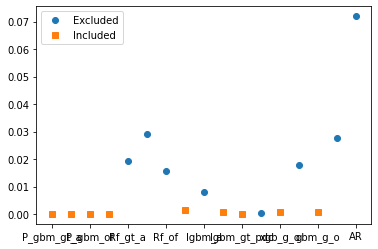

In [ ]:
status = pd.DataFrame([data.mean(0), data.mean(0)],
                      index=['Excluded', 'Included']).T
status.loc[status.index.isin(included), 'Excluded'] = np.nan
status.loc[status.index.isin(excluded), 'Included'] = np.nan
fig = status.plot(style=['o', 's'])